# Introduction
This Jupyter notebook contains the python code generating the figures in the paper:
"Energy-based Modelling of the Feedback Control of Biomolecular Systems with Cyclic Flow Modulation" by Peter J Gawthrop.

## Import some python code
The bond graph analysis uses a number of Python modules:

In [1]:
## Some useful imports

import BondGraphTools as bgt
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
#plt.rcParams.update({'font.size': 25})

import IPython.display as disp

## Stoichiometric analysis
import stoich as st

## SVG bg representation conversion
import svgBondGraph as sbg

## Stoichiometry to BG
import stoichBondGraph as stbg


## Modular bond graphs
import modularBondGraph as mbg

## Control systems package
import control as con


## Data structure copy
import copy

## For reimporting: use imp.reload(module)
import importlib as imp

## Saving and loading data
import pickle

## Set quiet=False for verbose output
quiet = True

## Plotting 

## invar = 'phi' #phi to phi transfer functions
## invar = 'X' #X to X transfer functions
invar = 'X'
        
if invar=='phi':
    ysymbol = r'\tilde{\phi}'
else:
    ysymbol = r'\tilde{x}'

## Model can be reinitialsed by setting True
## If False, processed models read from file
Initialise_model = False

Vary_P0 = False
PP0 = [0.05,0.1,0.2,0.5,1.0,2.0,5.0]

# Create modular BG systems.

In [2]:
def convertBG(name,quiet=True,flatten=True):
    
    svg = name+'.svg'
    
    print('Processing', svg)
    
    ## Convert svg to BGtools and import
    sbg.model(svg,quiet=quiet)
    exec(f'import {name}')
    exec(f'imp.reload({name})')
    if flatten:
        print('    Flattening')
        ## Create stoichiometry
        ss = eval(f'st.stoich({name}.model(),quiet=quiet)')
        
        ## Create flattened BG
        stbg.model(ss,filename=name)
        exec(f'imp.reload({name})')
 
    ## Stoichiometry
    print('    Computing stoichiometry')
        
    s = eval(f'st.stoich({name}.model(),quiet=quiet)')
        
    return s



Sfilename = 'S_BGFB.dat'
if Initialise_model:
    S = {} ## Stoichiometry of each system
    names = ['ecr','ECR','Path','bgfb','bgsl',
             'CFM','P','Pfb','Psl',
            'PI','PIfb','PIsl']
    TopLevel = []
    #TopLevel = ['mCoop','Pfb','PIfb','Pfb0','PIfb0','Pol','PIol','Pol0','PIol0']
    for name in names:
        flatten = not name in TopLevel
        s = convertBG(name+'_abg', flatten=flatten)
        S[name] = s
        
    Sfile = open(Sfilename, 'wb')
    pickle.dump(S, Sfile)
else:
    Sfile = open(Sfilename, 'rb')
    S = pickle.load(Sfile)
    

# Parameters

In [3]:
## Parameters
parameter = {}

K_F = 1e3
K_G = 1/K_F
kappa_con = 2.0
kappa_sys = 10.0
#K_P0 = 0.1

parameter['K_con_ecr_F'] = K_F
parameter['K_con_ecr_G'] = K_G
parameter['kappa_con_ecr_r1'] = kappa_con
parameter['kappa_con_ecr_r2'] = kappa_con

parameter['kappa_sys_r1'] = kappa_sys
parameter['kappa_sys_r2'] = kappa_sys
parameter['kappa_sys_r3'] = kappa_sys

#parameter['X0_D'] = 1e-6
parameter['kappa_rd'] = 1e0
#parameter['K_P0'] = K_P0


## Enzyme total
e_0 = 100


In [4]:
def latexTable():
    ## Save parameters as a latex table
    pars = ['K_F','K_G','kappa_con','kappa_sys','e_0']
    for par in pars:
        val = eval(par)
        if par[0] == 'k':
            Par = '\\'+par
            Par = Par.replace('con','c')
            Par = Par.replace('sys','s')
        else:
            Par = par
        print(f'    ${Par}$ & {val} \\\\')
latexTable()

    $K_F$ & 1000.0 \\
    $K_G$ & 0.001 \\
    $\kappa_c$ & 2.0 \\
    $\kappa_s$ & 10.0 \\
    $e_0$ & 100 \\


# Analysis

In [5]:
def SteadyState(s,sc,parameter={},X0=None,t_ss=1000):
    t = np.linspace(0,t_ss)
    dat = st.sim(s,sc=sc,t=t,parameter=parameter,X0=X0,tol=1e-4,quiet=quiet)
    X_ss = dat['X'][-1]
    V_ss = dat['V'][-1]
    #dX_ss = sc['N']@V_ss
    dX_ss = dat['dX'][-1]
    dXc_ss = dat['dXc'][-1]
    print(f'Steady-state finder error: {np.linalg.norm(dXc_ss):.2e}')
 
    return X_ss,V_ss


In [6]:
def tfError(G1,G2):
    omega = np.logspace(-2,2)
    mag1,ph1,w1 = con.bode_plot(G1,omega=omega,Plot=False)
    mag2,ph2,w2 = con.bode_plot(G2,omega=omega,Plot=False)
    err = np.linalg.norm(mag2-mag1)/np.linalg.norm(mag1)
    print(f'\n*** Transfer function error = {err:.2} ***\n')
    

def zapSmall(x,tol=1e-10,quiet=True):
    
    xx = np.zeros(len(x))
    for i,val in enumerate(x):
        if abs(val)>tol:
            xx[i] = x[i]
        else:
            if not quiet:
                print(f'Setting {i}th coefficient {val:.2} to zero')
    return xx
        
def extractTF(TF,sc,inp,outp,tol=None,quiet=False):
    
    chemostats = sc['chemostats']
    species = sc['species']
    reaction = sc['reaction']
    
    ## Index of input and output
    i_inp = chemostats.index(inp)
    
    if outp in chemostats:
        i_outp = chemostats.index(outp)
    elif outp in species:
        i_outp = species.index(outp)
    else:
        if outp in reaction:
            i_outp = reaction.index(outp)
        else:
            print(f'Output {outp} does not exist')
    #print(f'i_outp={i_outp}')
    
    ## Extract tf
    tf = con.minreal(TF[i_outp,i_inp],tol=tol,verbose=False)
    
    ## Set small coeffs to zero
    num = tf.num[0][0]
    #print(num)
    num = zapSmall(num)
    #print(num)
    tf.num = [[num]]
    
    return tf

In [7]:
def printTF(tf,blurb,inp,outp):
    gain = con.dcgain(tf)
    print(f'{blurb}{inp}-->{outp} ({gain:.3}){blurb}\n')
    print(tf)
    print(f'Gain:  {con.dcgain(tf)}')
    print(f'Poles: {con.pole(tf)}')
    print(f'Zeros: {con.zero(tf)}')

    
def Linearise(s,sc,Inp=[],Outp=['P'],
              X0=None,X_ss=None,V_ss=None,
              invar='X',
              quiet=True):

    ## Heading
    name = s['name']
    blurb = '\n====================\n'
    print(f'{blurb} Analysing {name}{blurb}')
    
#     ## Enzyme states
#     sp = s['species']
#     #print(sp)
#     X0 = np.ones(s['n_X'])
#     X0[sp.index('con_E0')] = e_0/3
#     X0[sp.index('con_E')] = e_0/3
#     X0[sp.index('con_C')] = e_0/3

       
    ## Steady state
    if X_ss is None:
        X_ss,V_ss = SteadyState(s,sc,X0=X0,parameter=parameter)
        #v_ss = V_ss[2]
        #print(f'v_ss = {v_ss:0.2}')
        #print(f'V_ss = {V_ss}')

    if len(Inp)>0:
        outvar='port'
    else:
        outvar=invar
        

    print(f'Outvar = {outvar}; invar = {invar}')
    Sys = st.lin(s,sc,x_ss=X_ss,parameter=parameter,
                 outvar=outvar,invar=invar,quiet=quiet)

    TF = con.tf(Sys)
    L = con.tf([0],[1])
    Gain = []
    for outp in Outp:
        for inp in Inp:
            tf = extractTF(TF,sc,inp,outp,tol=1e-4)
            gain = con.dcgain(tf)
            if not quiet:
                printTF(tf,blurb,inp,outp)
                
#             if (outp in ['P','Inh']) and (inp in ['P','Inh']):
#                 if not ( 
#                     (passive and (inp is 'Inh')) or
#                     (active  and (inp is 'P'))
#                 ):

            L = con.minreal(con.parallel(L,tf))
            Gain += [gain]
    g = np.sum(Gain)
    print(f'Net gain = {g:0.3}')

    ## Gain from P0
    inp = 'P0'
    outp = 'P'
    tf = extractTF(TF,sc,inp,outp)
    g = con.dcgain(tf)
    if not quiet:
        print(f'{inp}-->{outp} ({g:.3})\n')
        print(tf)
    G0 = tf
    
    ## Gain from D
    inp = 'D'
    outp = 'P'
    tf = extractTF(TF,sc,inp,outp)
    g = con.dcgain(tf)
    if not quiet:
        print(f'{inp}-->{outp} ({g:.3})\n')
    Gd = tf

    ## Change sign of L to conventional.
    L = con.negate(L)
    
    return L,G0,Gd,X_ss,V_ss

In [8]:
# def create(name,quiet=False):
#     ## Import system
#     name_abg = name+'_abg'
#     sbg.model(name_abg+'.svg')
#     exec('import '+name_abg)
#     exec('imp.reload('+name_abg+')')
#     model = eval(name_abg+'.model()')
#     #imp.reload(abg)
#     print(name_abg)
#     return model

In [9]:
def passive(G,G_act):
    print(G.num)
    print(G_act.num)

In [10]:
def setPtf(invar):
    ## Set transfer function of the product Ce
    if invar is 'phi':
        species = s_cl['species']
        X_ss_P = X_ss_cl[species.index('P')]
        Pgain = 1/X_ss_P
    else:
        Pgain = 1
    print(f'Pgain = {Pgain}')
    Ptf = con.tf([Pgain],[1,0]) 
    return Ptf
        
def OpenToClosed(L,G0,Gd,invar='X'):
    
    ## Set transfer function of the product Ce
    Ptf = setPtf(invar)
    
    ## Closed-loop from OL model
    CL0 = con.feedback(Ptf,L)
    CL = con.minreal(con.series(G0,CL0))
    CL_d = con.minreal(con.series(Gd,CL0))
    return CL,CL_d

def ParallelToSeries(L,La):

    nLa = La.num[0][0]
    dLa = La.den[0][0]
    print(nLa)
    print(dLa)
    
    iLa = con.tf(dLa,nLa)
   
    LP = con.series(iLa,L)
    #LP = con.minreal(LP)
    
    return LP


def phaseMargin(L,name):
    ## Stability margins
    #print(con.stability_margins(L))
    gm, pm, wg, wp = con.margin(L)
    print(f'{name}: pm = {int(pm)} degrees  at frequency {wp:.2} rad/s')

def plotNyquist(LL,LLa,LLp,P0,cont):
    plt.clf()
    BigFont=14
    Pad = 20
    plt.rcParams.update({'font.size': BigFont})
    omega = np.logspace(-2,4,500)
    re,im,w = con.nyquist_plot(LL,omega=omega,Plot=False)
    rea,ima,w = con.nyquist_plot(LLa,omega=omega,Plot=False)
    rep,imp,w = con.nyquist_plot(LLp,omega=omega,Plot=False)
#     Pass = (re + 1j*im)/(rea + 1j*ima)
#     reP = np.real(Pass)
#     imP = np.imag(Pass)
    
    th = np.linspace(0,1,100)*2*np.pi
    rec = np.cos(th)
    imc = np.sin(th)
    plt.axis('equal')
    plt.plot(re,im,label=r'$L(j\omega)$',lw=4)
    plt.plot(rep,imp,label=r'$L_{pas}(j\omega)$')
    #plt.plot(reP,imP,label=r'$L_{PAS}(j\omega)$')
    plt.plot(rea,ima,label=r'$L_{act}(j\omega)$')
    plt.plot(rec,imc,linestyle='dashed',label='Unit circle',color='black')
    plt.plot(-1,0,marker='X',ms=6,color='black')
    plt.xlim((-5,5))
    plt.ylim((-3,3))
    plt.legend()
    plt.grid()
    if P0 is not None:
        plt.title('$x_{P0}=$'+str(P0))
    plt.xlabel(r'Real $L(j\omega)$')
    plt.ylabel(r'Imag $L(j\omega)$')
    plt.savefig(''+cont+'_'+str(int(10*P0))+'_nyqL.pdf',
    box_inches='tight',pad_inches=Pad)
    #plt.savefig(''+name+f'_{P0:.1f}'+'.pdf')
    plt.show()
    plt.rcParams.update({'font.size': 10})

def loopGain(L,Lp,La,name='noname',invar='X',P0=1):
    
    ## Set transfer function of the product Ce
    Ptf = setPtf(invar)
    omega = np.logspace(-2,2,100)
    LL = con.series(Ptf,L)
    mag,phase,omega = con.bode_plot(LL,omega=omega,Plot=False)
    
    LLp = con.series(Ptf,Lp)
    magp,phasep,omega = con.bode_plot(LLp,omega=omega,Plot=False)
    
    LLa = con.series(Ptf,La)  
    maga,phasea,omega = con.bode_plot(LLa,omega=omega,Plot=False)
    
    LLap = con.series(Ptf,con.parallel(La,Lp))
    magap,phaseap,omega = con.bode_plot(LLap,omega=omega,Plot=False)
   
    ## Compute equivalent series passive transferfunction
    ## Not used just now.
    LLP = ParallelToSeries(LL,LLp)
    magP,phaseP,omega = con.bode_plot(LLP,omega=omega,Plot=False)
  

    
    ## Sanity check
    err = np.linalg.norm(magap-mag)/len(mag)
    print(f'Error = {err:0.2}')
    ## Margins
#     phaseMargin(LLp,'Passive')
#     phaseMargin(LLa,'Active')
    phaseMargin(LL,'Passive+Active')
    plotNyquist(LL,LLa,LLp,P0,name)
    

<>:3: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:3: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-10-b4a17af96eea>:3: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if invar is 'phi':


In [11]:
def closedLoop(s_cl,sc_cl,X0,T=None):

    ## Closed loop analysis


    ## Linearise
    L_cl,G0_cl,Gd_cl,X_ss_cl,V_ss_cl = Linearise(s_cl,sc_cl,X0=X0,invar=invar)
 
    ## Extract steady state
    x_P_ss = X_ss_cl[s_cl['species'].index('P')]
    print(f'Steady-state x_P = {x_P_ss}')
    v_ss = V_ss_cl[s_cl['reaction'].index('sys_r3')]
    
    if T is None:
        T = np.linspace(0,25,500)
        
    tt_cl,yy_cl = con.step_response(Gd_cl,T=T)
    
    return L_cl,G0_cl,Gd_cl,X_ss_cl,V_ss_cl,tt_cl,yy_cl,x_P_ss,v_ss

# L_cl,G0_cl,Gd_cl,X_ss_cl,tt_cl,yy_cl = closedLoop(s_cl,sc_cl,X0)
# plt.plot(tt_cl,yy_cl)

In [12]:
def plotBode(L,P0,cont):
    omega = np.logspace(-2,1,500)
    plt.clf()
    plt.grid(b=None)
    con.bode_plot(L,omega=omega)
    #Legend = ['passive+active','active','passive', 'passive(P)','passive(Inh)']
    #Legend = ['$G_{P}$','$G_{act}$','$G_{pas}$','$G_{PP}$','$G_{II}$']
    Legend = ['$G_{P}$','$G_{act}$','$G_{pas}$']
    plt.legend(Legend,loc='center right') 
    #plt.grid(False)
    #plt.title(f'P0 = {P0}')
    plt.savefig(''+cont+'_'+str(int(10*P0))+'_bodeG.pdf')
    plt.show()
    plt.clf()
     
def splitLoop(X_ss_cl,cont='P',invar='X',quiet=True):
    
    name = cont+'sl'
#     Psl = create(name,quiet=quiet)
#     disp.SVG(name+'_abg.svg')

    ## Stoichiometry: split-loop
    #s_sl = st.stoich(Psl,quiet=quiet)
    s_sl = S[name]
    chemostats_sl = chemostats_ol + ['Inh']
    sc_sl = st.statify(s_sl,chemostats=chemostats_sl)

    ## Copy steady states from closed-loop to split-loop
    # print(s_cl['species'])
    # print(s_sl['species'])
    X_ss = copy.copy(X_ss_cl)
    X_ss_sl = np.ones(s_sl['n_X'])
    species = s_cl['species']
    species_sl = s_sl['species']
    ## Common species
    for spec in species:
        X_ss_sl[species_sl.index(spec)] = X_ss[species.index(spec)]

    ## Inhibition
    X_ss_sl[species_sl.index('Inh')] = X_ss[species.index('P')]



    ## Linearise
    L_sl,G0_sl,Gd_sl,X_ss_sl,V_ss_sl = Linearise(s_sl,sc_sl,
                                         Inp=['Inh','P'],Outp=['Inh','P'], 
                                         X_ss=X_ss_sl,invar=invar,
                                                 quiet=quiet)
    #tfError(L_sl,L_ol)
    # print(L_sl)
    # print(L_ol)
    CLsl,CLsl_d = OpenToClosed(L_sl,G0_sl,Gd_sl,invar=invar)

    ## Passive only
    L_pp,G0_pp,Gd_pp,X_ss_pp,V_ss_pp = Linearise(s_sl,sc_sl,
                                         Inp=['P'],Outp=['P'], 
                                         X_ss=X_ss_sl,invar=invar
                                            ,quiet=quiet)
    
    L_ii,G0_p,Gd_p,X_ss_pp,V_ss_pp = Linearise(s_sl,sc_sl,
                                         Inp=['Inh'],Outp=['Inh'], 
                                         X_ss=X_ss_sl,invar=invar
                                            ,quiet=quiet)
    L_pi,G0_p,Gd_p,X_ss_pp,V_ss_pp = Linearise(s_sl,sc_sl,
                                         Inp=['P'],Outp=['Inh'], 
                                         X_ss=X_ss_sl,invar=invar
                                            ,quiet=quiet)
    
    L_i = con.parallel(L_ii,L_pi)
    
    L_p = con.parallel(L_pp,L_i)
    
       
    
    CLp,CLp_d = OpenToClosed(L_p,G0_p,Gd_p,invar=invar)


    # ## Passive only
    # L_p,G0_p,Gd_p,X_ss_p = Linearise(s_sl,sc_sl,
    #                                      Inp=['Inh','P','P0'],Outp=['P' ,'Inh'], 
    #                                      X_ss=X_ss_sl,
    #                                     passive = True)
    # CLp,CLp_d = OpenToClosed(L_p,G0_ol,Gd_ol)

    ## Active only
    L_a,G0_a,Gd_a,X_ss_a,V_ss_a = Linearise(s_sl,sc_sl,
                                         Inp=['Inh'],Outp=['P'], 
                                         X_ss=X_ss_sl,invar=invar,
                                            quiet=quiet)
  

    CLa,CLa_d = OpenToClosed(L_a,G0_ol,Gd_ol,invar=invar)
    
    ## Sanity check
    L_ap = con.parallel(L_p,L_a)
    tfError(L_sl,L_ap)

    ## The steady-state gains
    Gss_p = con.dcgain(Gd_p)/con.dcgain(L_p)
    Gss_a = con.dcgain(Gd_a)/con.dcgain(L_a)
    Gss_sl = con.dcgain(Gd_sl)/con.dcgain(L_sl)
    Gss = np.array([Gss_p,Gss_a,Gss_sl])
    
    ## Plot components of step
    P0 = X_ss_cl[species.index('P0')]
    TT = np.linspace(0,25,100)
    ttsl,yysl = con.step_response(CLsl_d,T=TT)
    tta,yya = con.step_response(CLa_d,T=TT)
    ttp,yyp = con.step_response(CLp_d,T=TT)
    tt,yy = con.step_response(CL_d,T=TT)
    
    BigFont=14
    Pad = 20
    plt.rcParams.update({'font.size': BigFont})
                        
    plt.plot(ttsl,yysl,label=f'Passive+Active ({Gss_sl:.2})')
    plt.plot(ttp,yyp,label=f'Passive ({Gss_p:.2})')
    plt.plot(tta,yya,label=f'Active ({Gss_a:.2})')
    plt.hlines([Gss_a,Gss_p,Gss_sl],
           np.min(ttp),np.max(ttp),
          linestyles='dashed')
    plt.xlabel('$t$')
    plt.ylabel(f'${ysymbol}_P$')
    plt.legend()
    plt.grid()
    plt.title('$x_{P0}=$'+str(P0))
    plt.savefig(''+cont+'_'+str(int(10*P0))+'_allstep.pdf',
    box_inches='tight',pad_inches=Pad)
    plt.rcParams.update({'font.size': 10})
    plt.show()
    plt.clf()
    
    ## Plot the gain functions
    #plotBode([L_sl,L_a,L_p,L_pp,L_i],P0,name)
    plotBode([L_sl,L_a,L_p],P0,name)
    
    ## Plot loop gain
    loopGain(L_sl,L_p,L_a,name=cont,invar=invar,P0=P0)
    

    Lss_p = con.dcgain(L_p)
    Lss_a = con.dcgain(L_a)
    Lss_sl = con.dcgain(L_sl)
    Lss = np.array([Lss_p,Lss_a,Lss_sl])
    
    return ttp,yyp,Gss,Lss

##ttp,yyp,Gss,Lss = splitLoop(X_ss_cl,cont='bg',invar=invar,quiet = True)



In [13]:
def Vary(PP0 = [1],cont='P',invar='X',X0=None):

    P_ss = []
    V_ss = []
    g_ss = []
    l_ss = []
    for P0 in PP0:
        print(f'Doing X0_P0 = {P0}')
        
        ## Parameters
        if cont in ['P']:
            prefixes = ['con_P_']
        else:
            prefixes = ['con_P_','con_I_']
    
        if X0 is None:
            parameter,X0 = setParameter(s_cl,N=0,e_0=e_0,
                                 prefixes=prefixes)

        X0[s_cl['species'].index('P0')] = P0
        #print(parameter)
        
        ## Closed-loop
        L_cl,G0_cl,Gd_cl,X_ss_cl,V_ss_cl,tt_ECR_cl,yy_ECR_cl,x_P_ss,v_ss = closedLoop(s_cl,sc_cl,X0)
        
        ## Split-loop
        ttp,yyp,Gss,Lss = splitLoop(X_ss_cl,cont=cont,invar=invar)
        
        P_ss.append(x_P_ss)
        V_ss.append(v_ss)
        g_ss.append(Gss[2])
        l_ss.append(Lss[2])
                                         
                 
           
    return P_ss,V_ss,g_ss,l_ss


In [14]:
#print(P_ss,g_ss)

In [15]:
def nsim(s_cl,sc_cl,X_ss_cl,tt,yy,Amp=[1,0.1],
         invar='X',g_D=None,quiet=True,name=None):
    
    ## Exported data
    Dat = {}
    Dat['t'] = tt
    
    ## Names
    species = s_cl['species']
    reaction = s_cl['reaction']
    
    usePhi = invar == 'phi'
    
#     if name in ['bgfb_sim']:
#         label = None
#     else:
    label = 'Linearised'
        
    plt.plot(tt,yy,lw=6,label=label)
    
    if g_D is not None:
        label = f'$g_D = {g_D:0.2}$'
        plt.hlines(g_D,np.min(tt),np.max(tt),linestyles='dashed',label=label)
    
#     if name is 'bgfb_sim':
#         AMP = [1]
#     else:
#         AMP = Amp
        
    for amp in Amp:
        ## Non-linear simulation
        ##species = s_cl['species']
        X0_D = X_ss_cl[species.index('D')]
        chemo = '{0}+{1}*np.heaviside(t-{2},1)'.format(X0_D,amp,0)
        X_chemo =  {'D':chemo}

        dat = st.sim(s_cl,sc=sc_cl,t=tt,
                     parameter=parameter,X0=X_ss_cl,
                     X_chemo=X_chemo,quiet=quiet)

        ## Extract state
        x_P = dat['X'][:,species.index('P')]
        x_P_ss = X_ss_cl[species.index('P')]
        dx_P = x_P-x_P_ss

        print(f'x_P_ss = {x_P_ss}')

        ## Extract phi
        phi_P = dat['phi'][:,species.index('P')]
        phi_P_ss = dat['phi'][0,species.index('P')]
        dphi_P = (phi_P-phi_P_ss)/st.V_N()
        
        ## Extract power dissipation
        P_Re = dat['P_Re']
        
        P_con = np.zeros(len(tt))
        P_sys = np.zeros(len(tt))
        for r in reaction:
            if 'con_' in r:
                #print(r)
                P_con += P_Re[:,reaction.index(r)]
                
            if ('sys_' in r) or (r == 'rd'):
                #print(r)
                P_sys += P_Re[:,reaction.index(r)]

        if usePhi:
            plt.plot(tt,dphi_P/amp,label=f'Non-linear ({amp})')
        else:
            plt.plot(tt,dx_P/amp,label=f'Non-linear ({amp})')
            
        if amp == 1:
            Dat['dx_P'] = dx_P
            Dat['P_con'] = P_con
            Dat['P_sys'] = P_sys
            
 


    plt.legend()
    plt.grid()
    plt.xlabel('$t$')

        
    plt.ylabel(f'${ysymbol}_P$ (normalised)')
        
    if name is not None:
        plt.savefig(''+name+'.pdf')
        
    plt.show()
        
    if name == 'PI_sim':
        st.plot(s_cl,dat,species=['con_Int'],reaction=[]) 
        
#     for i,spec in enumerate(s_cl['species']):
#         print(f'$x_{spec} = {X_ss_cl[i]:.2f}$')
        
    return Dat

#nsim(s_cl,sc_cl,X_ss_cl,tt_PI_cl,yy_PI_cl,name='PI_sim',invar=invar,g_D=Gss_PI[2])
        


In [16]:
def SteadySim(s_cl,sc_cl,X_ss_cl,Amp=[1,0.1],
         invar='X',quiet=True,name=None):
    
    usePhi = invar == 'phi'
    
    species = s_cl['species']
    reaction = s_cl['reaction']
    
    ## Initial steady-state
    X0_P0 = 1e-1
    X_ss_0 = X_ss_cl
    X_ss_0[species.index('P0')] = X0_P0
    X_ss,V_ss = SteadyState(s_cl,sc_cl,parameter=parameter,X0=X_ss_0,t_ss=10000)


    ## Non-linear simulation
    Last = 1e6
    t = np.linspace(0,Last,10000)

    chemo = f'{X0_P0}+10*t/{Last}'
    x_P0 = X0_P0 + 10*t/Last
    X_chemo =  {'P0':chemo}
    print(X_chemo)

    dat = st.sim(s_cl,sc=sc_cl,t=t,
                 parameter=parameter,X0=X_ss,
                 X_chemo=X_chemo,quiet=quiet)

    ## Extract state
    x_P = dat['X'][:,species.index('P')]
    x_P_ss = X_ss_cl[species.index('P')]
    dX_P = x_P-x_P_ss
    
    ## Extract flow
    f = dat['V'][:,reaction.index('sys_r2')]

    ## Extract phi
    phi_P = dat['phi'][:,species.index('P')]
    phi_P_ss = dat['phi'][0,species.index('P')]
    dphi_P = (phi_P-phi_P_ss)/st.V_N()

    plt.plot(x_P0,x_P)
    plt.grid()
    plt.xlabel('$x_{P0}$')
    plt.ylabel('$x_P$')
    if name is not None:
        plt.savefig(''+name+'_ss.pdf')  
    plt.show()
    
    plt.plot(x_P0,f)
    plt.grid()
    plt.xlabel('$x_{P0}$')
    plt.ylabel('$f$')
    if name is not None:
        plt.savefig(''+name+'_ss_f.pdf')  
    plt.show()       

    return x_P0,x_P,f


#x_P0,x_P,f = SteadySim(s_cl,sc_cl,X_ss_cl,name='PI_sim',invar=invar)
        


# Enzyme-catalysed reaction with activation and inhibition

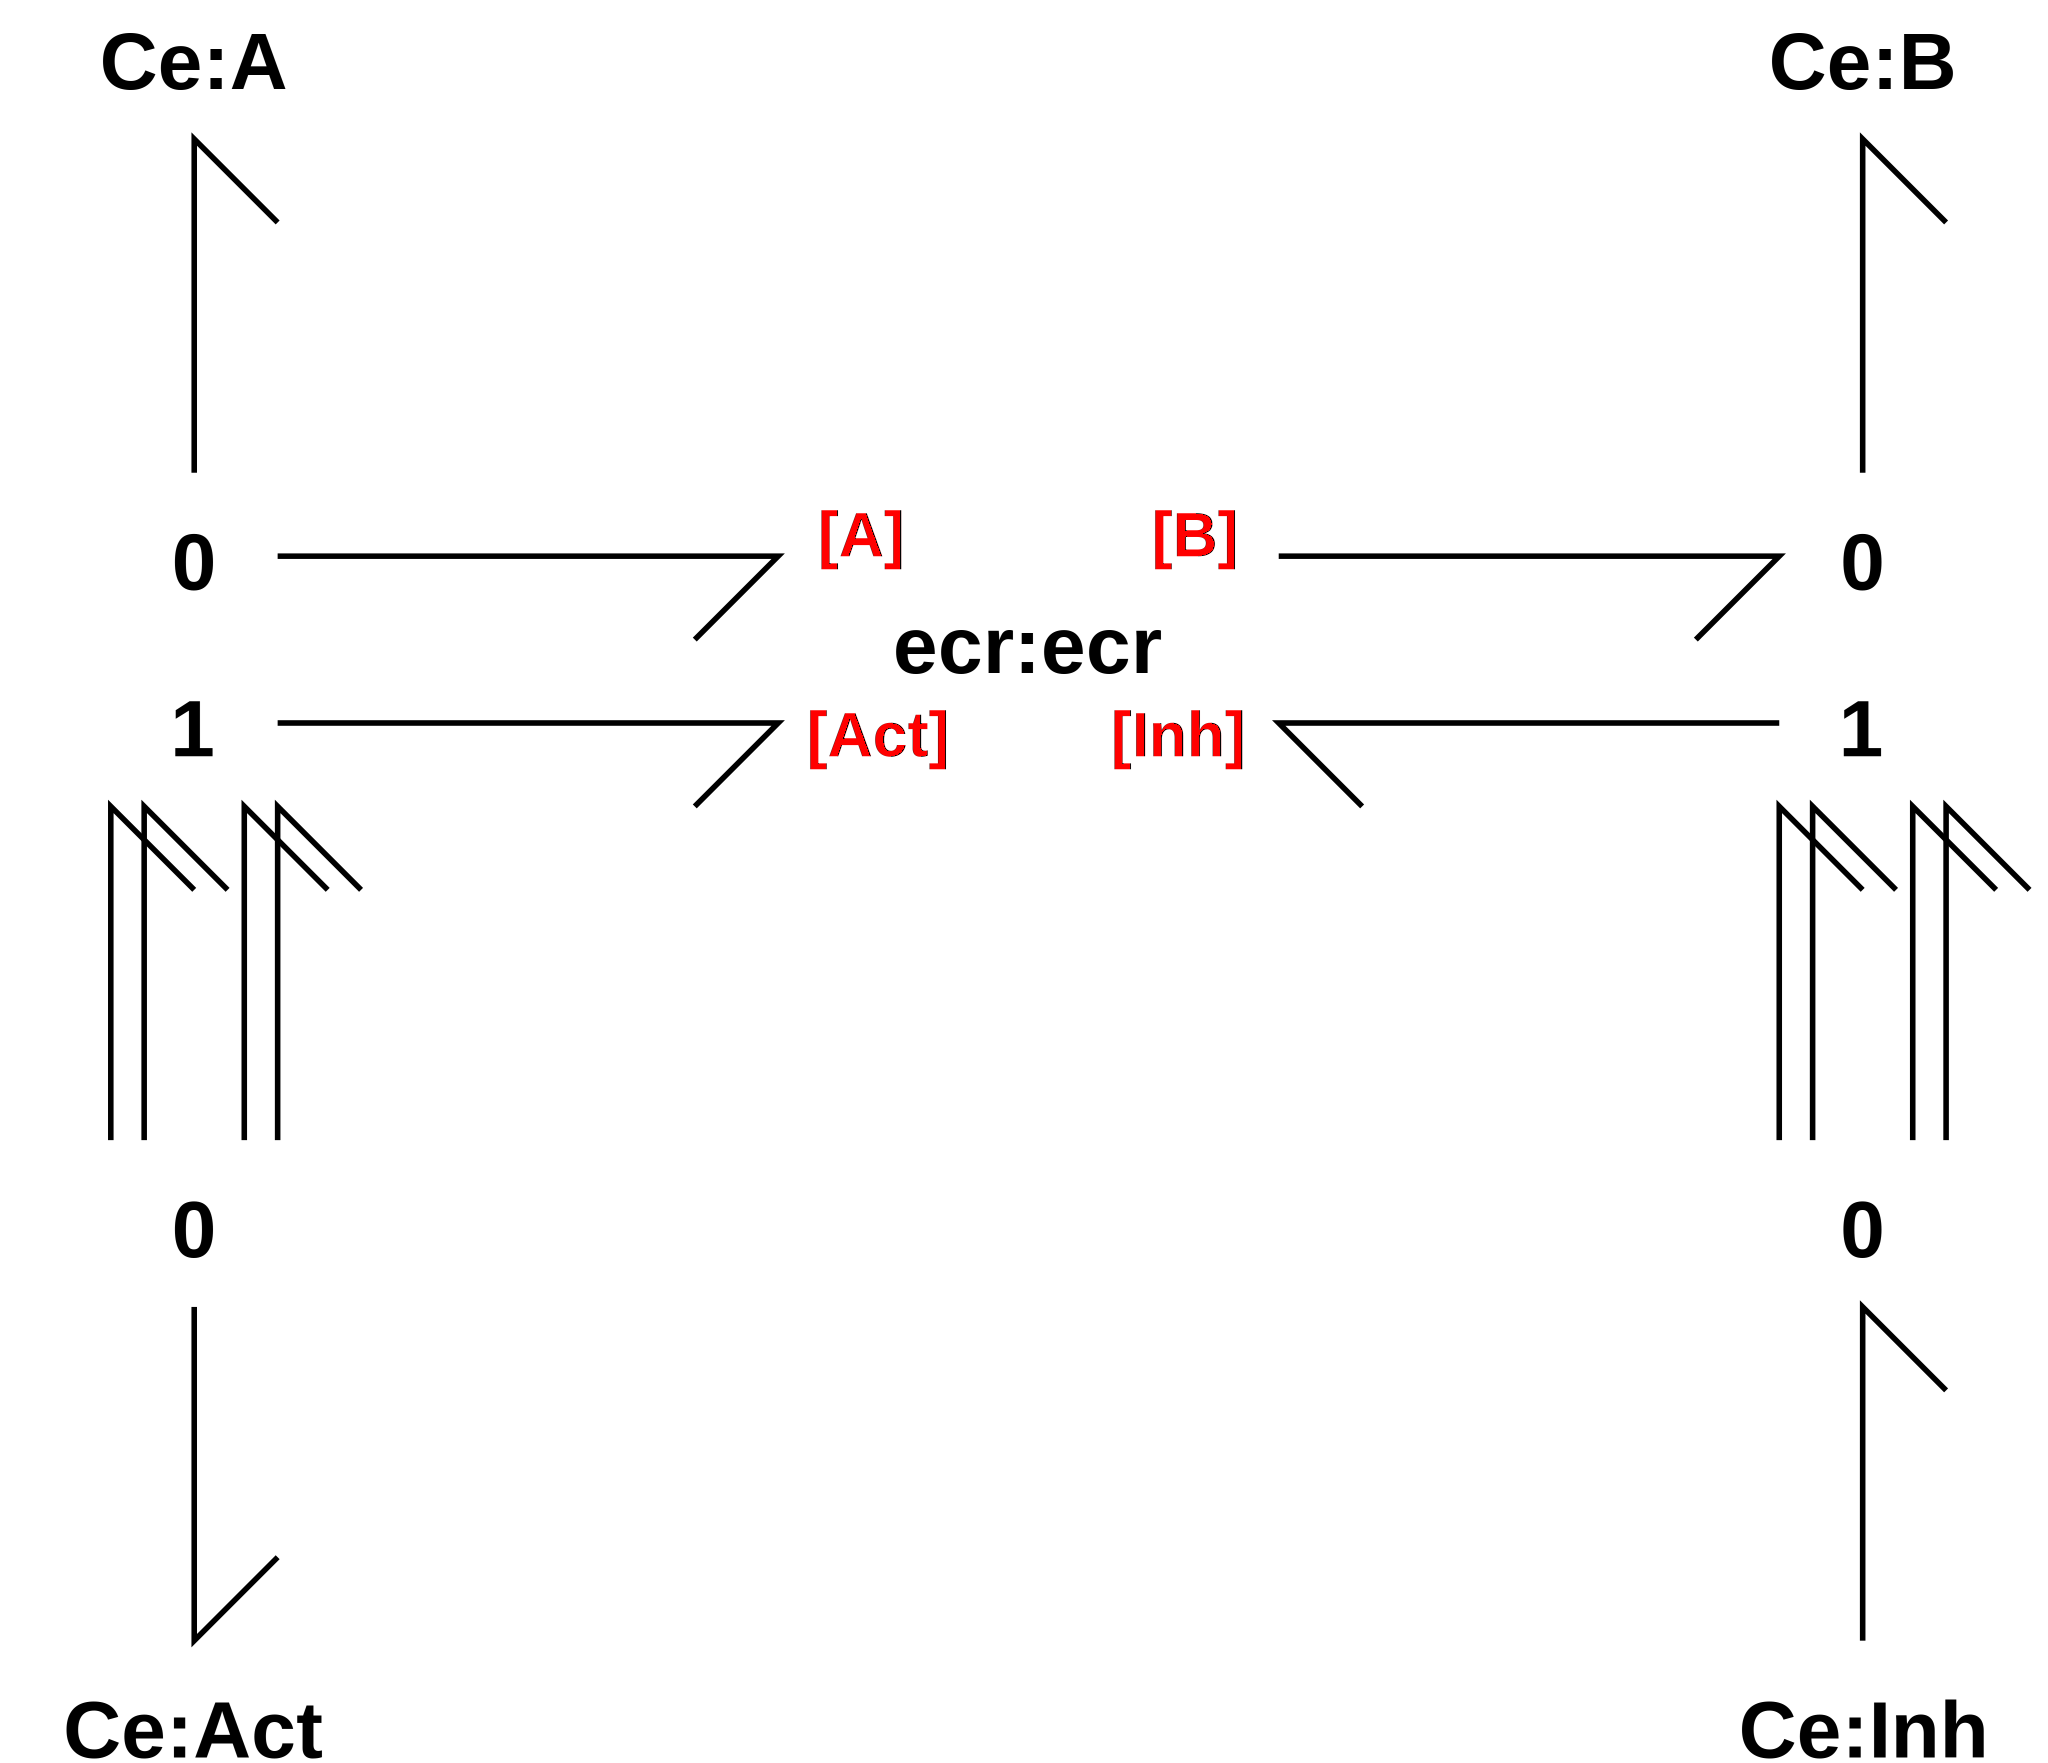

In [17]:
name = 'ECR'
#ECR = create(name,quiet=quiet)
disp.SVG(name+'_abg.svg')

## Reaction pathway


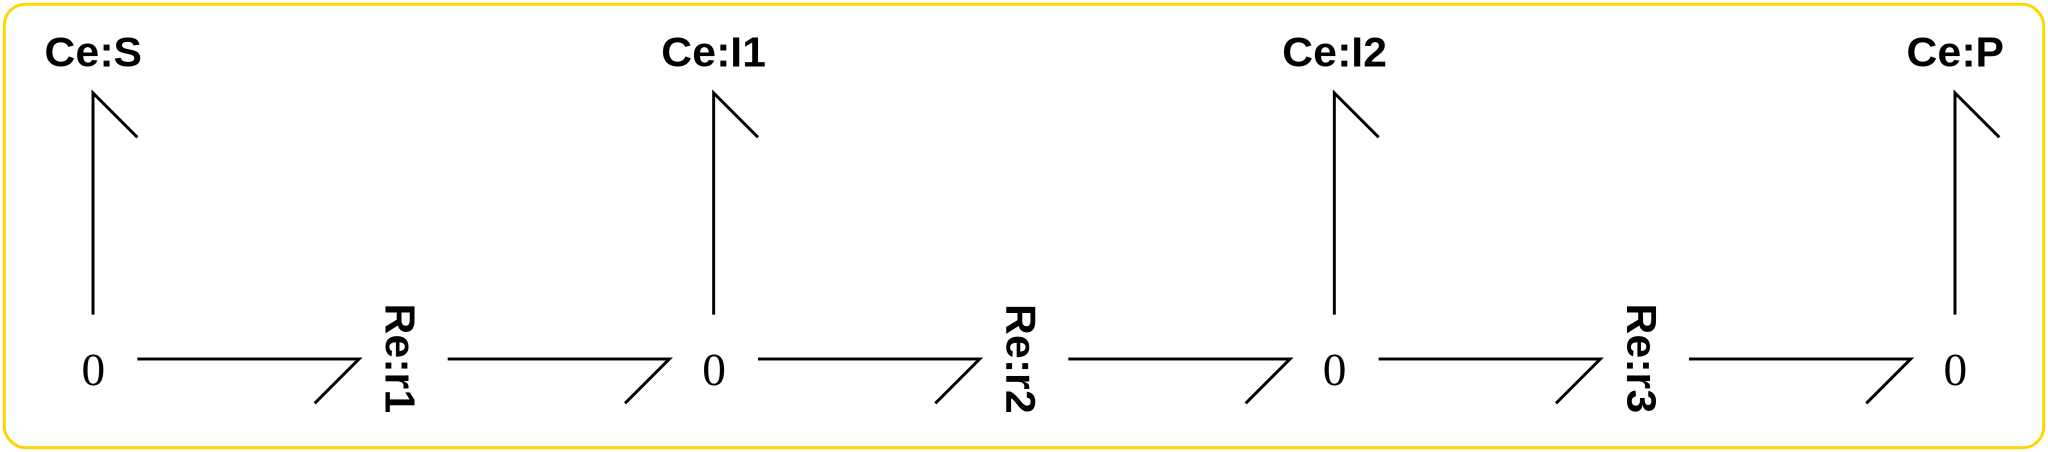

In [18]:
name = 'Path'
#Path = create(name,quiet=quiet)
disp.SVG(name+'_abg.svg')

# Feedback control (ECR)


## Closed-loop

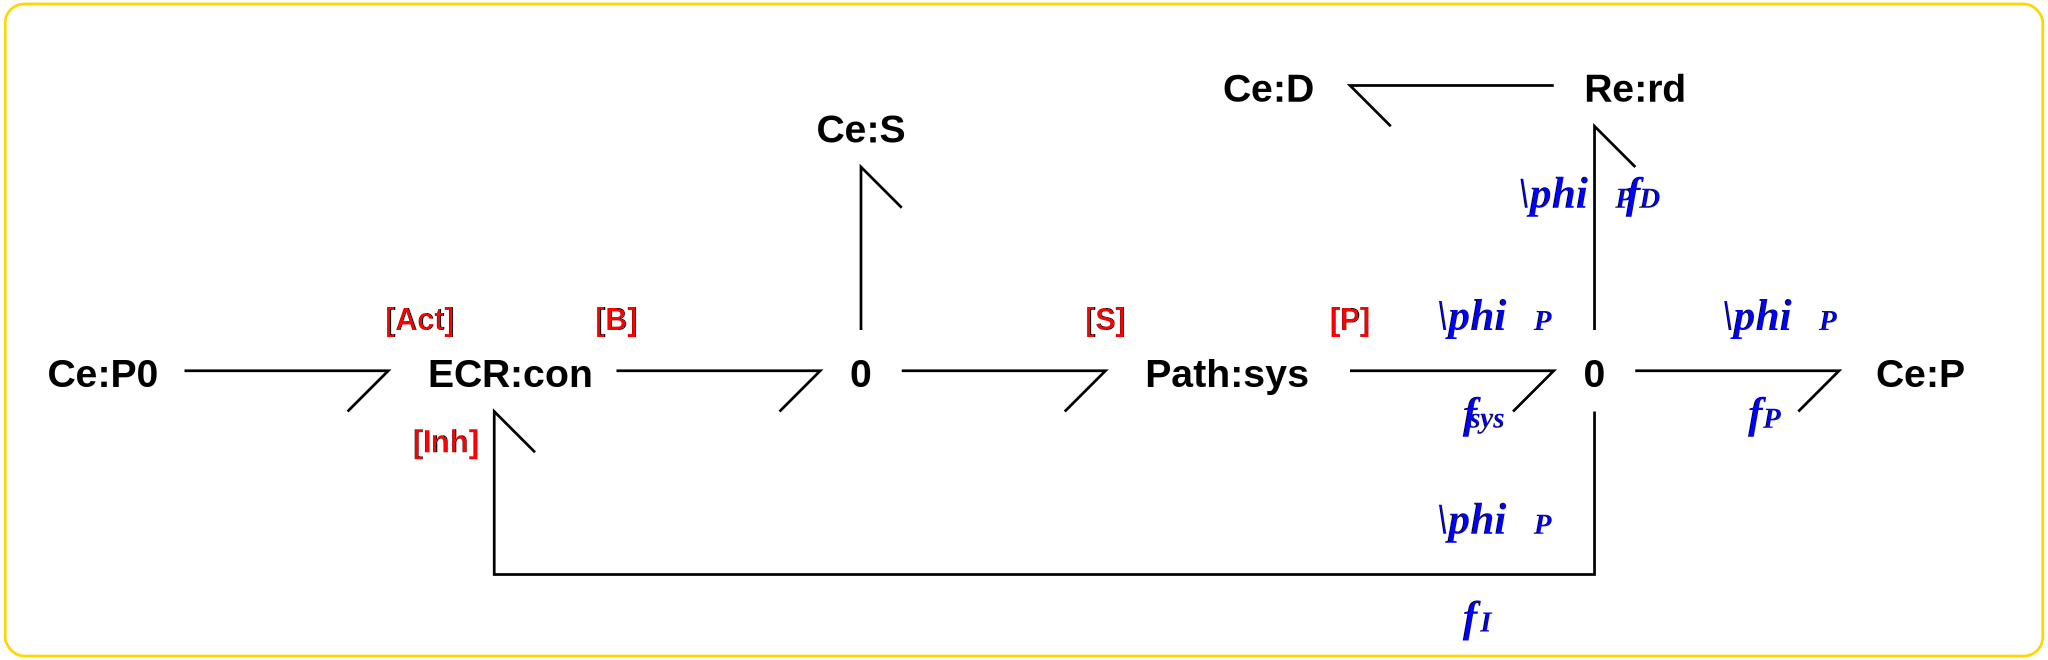

In [19]:
name = 'bgfb'
#bgfb = create(name,quiet=quiet)
disp.SVG(name+'_abg.svg')

In [20]:
## Stoichiometry: closed-loop
#s_cl = st.stoich(bgfb,quiet=quiet)
s_cl = S[name]
#chemostats_cl = ['con_A','con_E0','con_F','con_G', 'P0','D']
chemostats_cl = ['con_A','con_ecr_F','con_ecr_G', 'P0','D']
sc_cl = st.statify(s_cl,chemostats=chemostats_cl)

In [21]:
## Closed loop analysis
sp = s_cl['species']
print(sp)
X0 = np.ones(s_cl['n_X'])
X0[sp.index('con_ecr_E0')] = e_0/3
X0[sp.index('con_ecr_E')] = e_0/3
X0[sp.index('con_ecr_C')] = e_0/3

L_cl,G0_cl,Gd_cl,X_ss_cl,V_ss_cl,tt_ECR_cl,yy_ECR_cl,x_P_ss,v_P_ss = closedLoop(s_cl,sc_cl,X0)
# print(x_P_ss)
# print(v_P_ss)
# print(L_cl)
print(Gd_cl)

['D', 'P', 'P0', 'S', 'con_A', 'con_ecr_C', 'con_ecr_E', 'con_ecr_E0', 'con_ecr_F', 'con_ecr_G', 'sys_I1', 'sys_I2']

 Analysing bgfb

Steady-state finder error: 3.73e-13
Outvar = X; invar = X
Net gain = 0.0
Steady-state x_P = 10.11533380416622

        s^5 + 1.252e+04 s^4 + 6.682e+05 s^3 + 9.68e+06 s^2 + 3.88e+07 s + 4.388e+07
-------------------------------------------------------------------------------------------
s^6 + 1.269e+04 s^5 + 1.116e+06 s^4 + 3.1e+07 s^3 + 2.851e+08 s^2 + 5.168e+08 s + 1.948e+08



## Open-loop


In [22]:
## Stoichiometry: open-loop
s_ol = s_cl
chemostats_ol = chemostats_cl + ['P']
sc_ol = st.statify(s_ol,chemostats=chemostats_ol)

In [23]:
## Linearise
L_ol,G0_ol,Gd_ol,X_ss_ol,V_ss_ol = Linearise(s_ol,sc_ol,
                                     Inp=['P'],Outp=['P'],
                                     invar=invar, X_ss=X_ss_cl,V_ss=V_ss_cl)
print(L_ol)
# print(G0_ol)
# print(Gd_ol)


 Analysing bgfb

Outvar = port; invar = X
0 states have been removed from the model
Net gain = -4.44

162 s^5 + 4.477e+05 s^4 + 2.132e+07 s^3 + 2.463e+08 s^2 + 4.73e+08 s + 1.948e+08
--------------------------------------------------------------------------------
  s^5 + 1.252e+04 s^4 + 6.682e+05 s^3 + 9.68e+06 s^2 + 3.88e+07 s + 4.388e+07



Pgain = 1
5 states have been removed from the model
0 states have been removed from the model

*** Transfer function error = 7.7e-13 ***


*** Transfer function error = 1.7e-12 ***

gd = 0.23


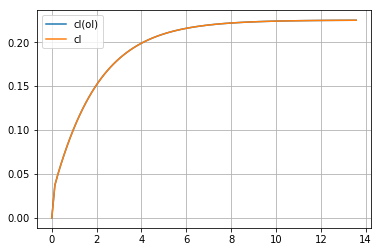

In [24]:
##Closed-loop from open loop
CL,CL_d = OpenToClosed(L_ol,G0_ol,Gd_ol,invar=invar)

tfError(CL,G0_cl)
tfError(CL_d,Gd_cl)

tt_ECR,yy_ECR = con.step_response(Gd_cl)
tt_d,yy_d = con.step_response(CL_d)
gd = con.dcgain(Gd_cl)
#L0 = con.dcgain(L_ol)
g_p = con.dcgain(L_ol)
#print(f'L0 = {L0:.2}')
print(f'gd = {gd:.2}')



plt.plot(tt_d,yy_d,label='cl(ol)')
plt.plot(tt_ECR,yy_ECR,label='cl')
#plt.hlines(gd,np.min(tt_d),np.max(tt_d),linestyles='dashed',label='$1/G_{pp}(0)$')
plt.legend()
#plt.ylim((0,1))
plt.grid()

## Split-loop


 Analysing bgsl

Outvar = port; invar = X
0 states have been removed from the model
5 states have been removed from the model
2 states have been removed from the model
3 states have been removed from the model
Net gain = -4.44
Pgain = 1
5 states have been removed from the model
0 states have been removed from the model

 Analysing bgsl

Outvar = port; invar = X
0 states have been removed from the model
Net gain = -1.0

 Analysing bgsl

Outvar = port; invar = X
0 states have been removed from the model
Net gain = -6.61e-12

 Analysing bgsl

Outvar = port; invar = X
0 states have been removed from the model
Net gain = 6.35e-12
Pgain = 1
10 states have been removed from the model
5 states have been removed from the model

 Analysing bgsl

Outvar = port; invar = X
0 states have been removed from the model
Net gain = -3.44
Pgain = 1
5 states have been removed from the model
1 states have been removed from the model

*** Transfer function error = 3.8e-07 ***



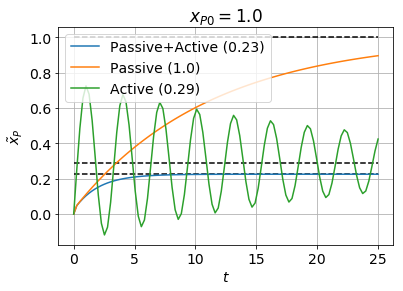

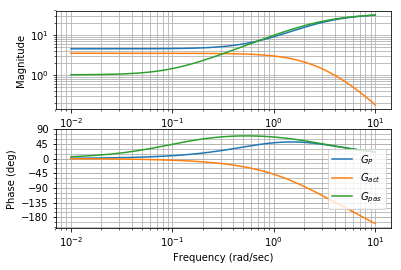

Pgain = 1
[1.61951974e+02 2.47607957e+06 5.73705468e+09 5.67955877e+11
 2.16689227e+13 3.94223822e+14 3.54760987e+15 1.51006331e+16
 2.95858696e+16 2.24570349e+16 1.92562343e+15]
[1.00000000e+00 2.50488072e+04 1.58197090e+08 1.67570212e+10
 6.89037100e+11 1.39080938e+13 1.46653357e+14 8.09856592e+14
 2.35522986e+15 3.40551638e+15 1.92560032e+15 0.00000000e+00]
Error = 4.2e-06
Passive+Active: pm = 98 degrees  at frequency 3.4e+01 rad/s


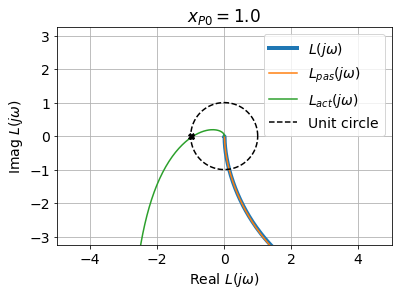

In [25]:
ttp,yyp,Gss,Lss = splitLoop(X_ss_cl,cont='bg',invar=invar,quiet=quiet)

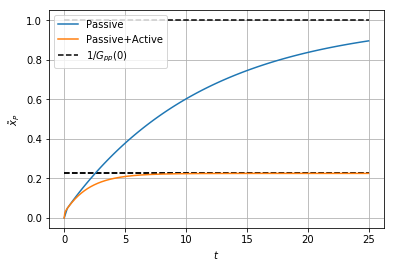

In [26]:
## Compare controllers
plt.hlines(1/g_p,np.min(ttp),np.max(ttp),linestyles='dashed',label='$1/G_{pp}(0)$')
plt.plot(ttp,yyp,label='Passive')
#plt.plot(tt_ECR,yy_ECR,label='ECR')
plt.plot(tt_ECR_cl,yy_ECR_cl,label='Passive+Active')
plt.hlines([Gss[0],Gss[2]],
           np.min(tt_ECR_cl),np.max(tt_ECR_cl),
          linestyles='dashed')
plt.legend()
plt.grid()
plt.xlabel('$t$')
plt.ylabel(f'${ysymbol}_P$')
#plt.ylim((0,1))
#plt.show()
plt.savefig('bgfb_step.pdf')
#plt.ylim((0,1))
#plt.show()
#plt.savefig('bgfb_step.pdf')

## Nonlinear simulation

x_P_ss = 10.11533380416622
x_P_ss = 10.11533380416622


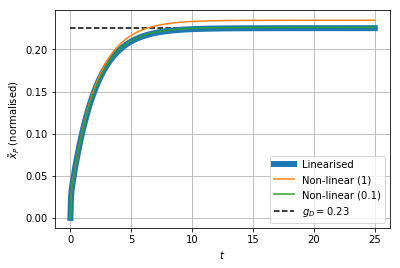

In [27]:
## Compare linear and non-linear   
dat_ECR = nsim(s_cl,sc_cl,X_ss_cl,tt_ECR_cl,yy_ECR_cl,
     invar=invar,g_D=Gss[2],name='bgfb_sim')

Steady-state finder error: 3.72e-15
{'P0': '0.1+10*t/1000000.0'}


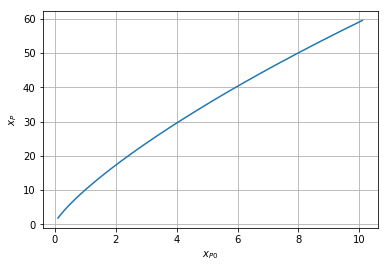

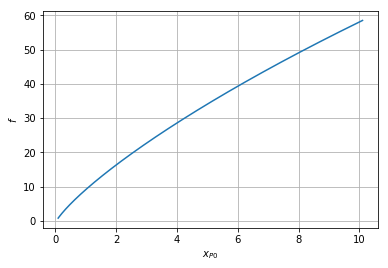

In [28]:
## Steady states
x_P0_ECR,x_P_ECR,f_ECR = SteadySim(s_cl,sc_cl,X_ss_cl,name='bgfb_sim',invar=invar)

## Vary $x_{P0}$

In [29]:
if Vary_P0:
    P_ss_ECR,V_ss_ECR,g_ss_ECR,l_ss_ECR = Vary(PP0 = PP0,cont='bg',invar='X',X0=X_ss_cl)

# Cyclic flow modulation: P control (CFM)

## Closed-loop

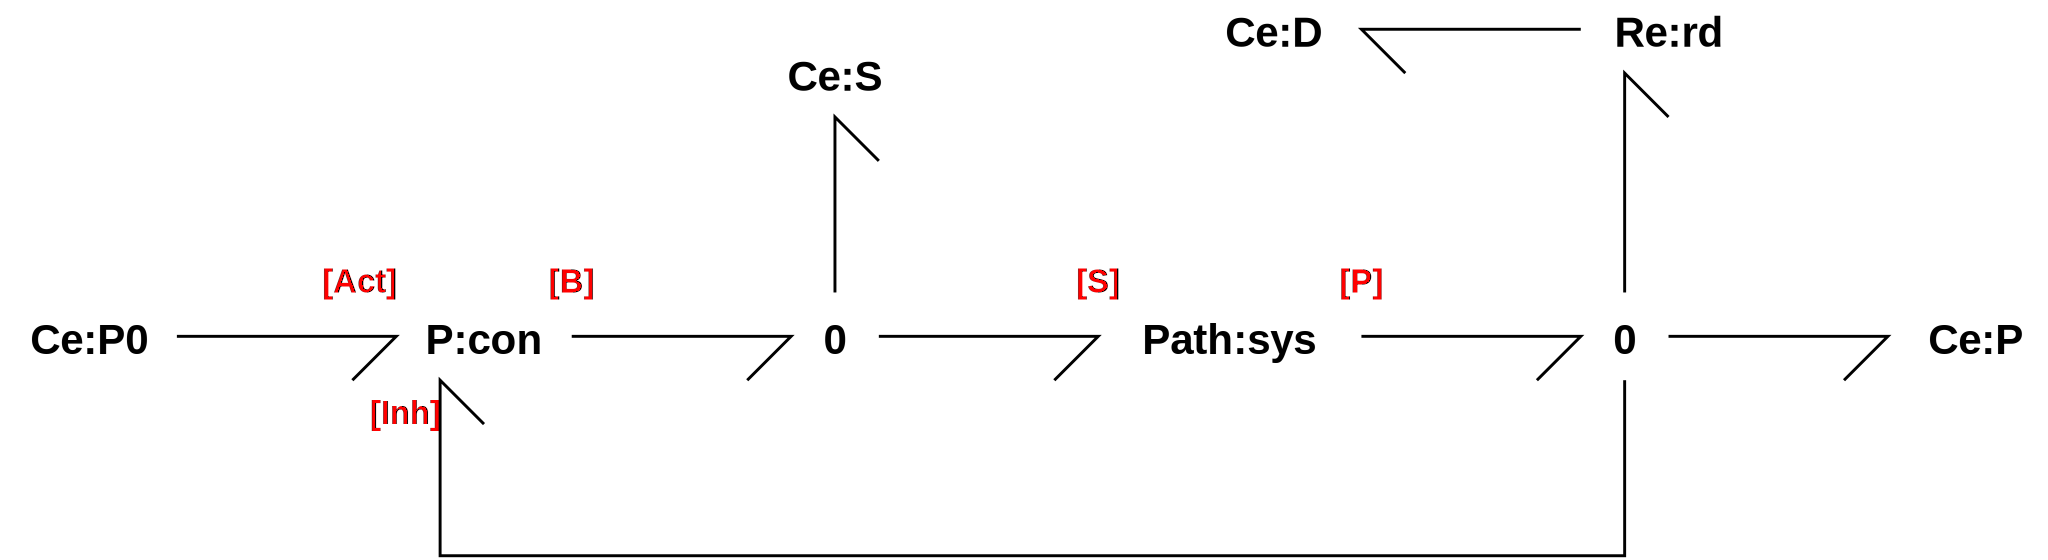

In [30]:
name = 'Pfb'
# Pfb = create(name,quiet=quiet)
disp.SVG(name+'_abg.svg')

In [31]:
## Stoichiometry: closed-loop
#s_cl = st.stoich(Pfb,quiet=quiet)
#chemostats_cl = ['con_A','con_E0','con_F','con_G', 'P0','D']
#chemostats_cl = ['con_A','con_F','con_G', 'P0','D']
s_cl = S[name]
#print(s_cl['species'])
chemostats_cl = ['P0','D']
chemostats_cl += ['con_A'] 
chemostats_cl += ['con_P_Fwd_ecr_F', 'con_P_Fwd_ecr_G','con_P_Rev_ecr_F', 'con_P_Rev_ecr_G']
sc_cl = st.statify(s_cl,chemostats=chemostats_cl)

In [32]:
#print(s_cl['species'])

In [33]:
## Set up some parameters
def setParameter(s,N=2,e_0=1e3,K_0=1,Integrator=False,prefixes=[''],Prefix='',X_P_ss=None,kappa_rd=1):

    ## Set up the non-unit parameters and states
    
    ## Default initial state
    X0 = np.ones(s['n_X'])   
        
    ## Species and reactions
    species = s['species']
    reaction = s['reaction']
    
    ## Initialise parameter dict
    parameter = {}
    
    if 'rd' in reaction:
        parameter['kappa_rd'] = kappa_rd

    
    for prefix in prefixes:
        if prefix is '':
            integrator = Integrator
        else:
            if prefix in ['I_','con_I_']:
                integrator = True
            else:
                integrator = False
        
#         ## Cycle driving potentials
#         if integrator:
#             K_BB = 1 # 1e-6
#             K_out= 1
#         else:
#             K_BB = 1 # 1e-6
#             K_out = 1
            
        KK = 'K_'+prefix
        kkappa = 'kappa_'+prefix
        #XX0 = 'X0_'+prefix
        
#         parameter[KK+'BBf'] = K_BB
#         parameter[KK+'AAr'] = K_BB*K_out
#         parameter[KK+'BBr'] = K_out
        
        for fr in ['Fwd_ecr','Rev_ecr']:
            X0[species.index(prefix+fr+'_E0')] = e_0/3
            X0[species.index(prefix+fr+'_E')] = e_0/3
            X0[species.index(prefix+fr+'_C')] = e_0/3
            
            
            if prefix in ['con_I_']:
                K_F_I = 1e2
                kappa_con_I = 200
                e0_I = 2
                parameter[KK+fr+'_F'] = K_F_I
                parameter[KK+fr+'_G'] = 1/K_F_I
                
                parameter[kkappa+fr+'_r1'] = kappa_con
                parameter[kkappa+fr+'_r2'] = kappa_con
                
                X0[species.index(prefix+fr+'_E0')] = e0_I/3
                X0[species.index(prefix+fr+'_E')] = e0_I/3
                X0[species.index(prefix+fr+'_C')] = e0_I/3
            else:    
                parameter[KK+fr+'_F'] = K_F
                parameter[KK+fr+'_G'] = 1/K_F
  
                parameter[kkappa+fr+'_r1'] = kappa_con
                parameter[kkappa+fr+'_r2'] = kappa_con

                X0[species.index(prefix+fr+'_E0')] = e_0/3
                X0[species.index(prefix+fr+'_E')] = e_0/3
                X0[species.index(prefix+fr+'_C')] = e_0/3
        
        
#         ## Reaction constants for forward and reverse reactions
#         kappa = {}
#         kappa['Fwd'] = kappa_con
#         kappa['Rev'] = kappa_con
        

        
        ## Species A constant
        K_A = 1
        
        ## Integrator constant
        K_Int = 1e0
        if integrator:
            if prefix is '':
                parameter['K_B']= K_Int
                #X0[species.index('B')] = 1/K_Int
            else:
                if prefix is 'con_I_':
                    parameter['K_con_Int'] = K_Int
                    X0[species.index('con_Int')] = 1/K_Int
                else:
                    parameter['K_Int']= K_Int
                    X0[species.index('Int')] = 1/K_Int
                    


        if 'con_A' in species:
            parameter['K_con_A'] = K_A
        else:
            parameter['K_A'] = K_A
            
        if X_P_ss is not None:
            if 'P' in species:
                ## Closed-loop version
                X0[species.index('P')] = X_P_ss
            else:
                ## Control module
                X0[species.index('B')] = X_P_ss
                X0[species.index('Inh')] = X_P_ss
                
#         if 'P' in species:
#             X0[species.index('P')] = 1
            
        if 'D' in species:
            X0[species.index('D')] = 1 #1e-2
        
            
    ## Path parameters
    parameter['kappa_sys_r1'] = kappa_sys
    parameter['kappa_sys_r2'] = kappa_sys
    parameter['kappa_sys_r3'] = kappa_sys

    
    #print(parameter)           
    return parameter,X0

parameter,X0 =  setParameter(s_cl,N=2,e_0=e_0,prefixes=['con_P_'])


<>:21: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:89: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:93: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:21: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:89: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:93: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-33-7eb4dcd1330a>:21: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if prefix is '':
<ipython-input-33-7eb4dcd1330a>:89: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if prefix is '':
<ipython-input-33-7eb4dcd1330a>:93: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if prefix is 'con_I_':


In [34]:
# ## Linearise
# L_CL,G0_CL,Gd_CL,X_ss_cl = Linearise(s_cl,sc_cl,X0=X0,invar=invar)

# T = np.linspace(0,25,100)
# ## Step response
# tt_P_cl,yy_P_cl = con.step_response(Gd_CL,T=T)
# # plt.plot(tt_cl,yy_cl)
# # plt.grid()
# x_P_ss = X_ss_cl[s_cl['species'].index('P')]
# print(f'Steady-state x_P = {x_P_ss}')

In [35]:
L_cl,G0_cl,Gd_cl,X_ss_cl,V_ss_cl,tt_P_cl,yy_P_cl,x_P_ss,v_P_ss = closedLoop(s_cl,sc_cl,X0)



 Analysing Pfb

Steady-state finder error: 6.24e-14
Outvar = X; invar = X
Net gain = 0.0
Steady-state x_P = 0.9999999999999871


## Open-loop


In [36]:
## Stoichiometry: open-loop
#s_ol = st.stoich(Pfb,quiet=quiet)
s_ol = s_cl
chemostats_ol = chemostats_cl + ['P']
sc_ol = st.statify(s_ol,chemostats=chemostats_ol)

In [37]:
## Linearise
L_ol,G0_ol,Gd_ol,X_ss_ol,V_ss_ol = Linearise(s_ol,sc_ol,Inp=['P'],Outp=['P'], 
                                     invar=invar,X_ss=X_ss_cl)
# print(L_ol)
# print(G0_ol)
# print(Gd_ol)


 Analysing Pfb

Outvar = port; invar = X
0 states have been removed from the model
Net gain = -4.21


Pgain = 1
7 states have been removed from the model
2 states have been removed from the model

*** Transfer function error = 1.3e-06 ***


*** Transfer function error = 2e-13 ***

g0 = 0.61


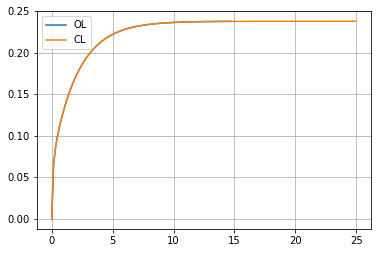

In [38]:
##Closed-loop from open loop
CL,CL_d = OpenToClosed(L_ol,G0_ol,Gd_ol)

tfError(CL,G0_cl)
tfError(CL_d,Gd_cl)

tt,yy = con.step_response(CL)
tt_d,yy_d = con.step_response(CL_d)
g0 = con.dcgain(G0_cl)
print(f'g0 = {g0:.2}')
#plt.plot(tt,yy/g0,label='P0 (normalised)')
plt.plot(tt_d,yy_d,label='OL')
plt.plot(tt_P_cl,yy_P_cl,label='CL')
plt.legend()
plt.grid()

## Split-loop


 Analysing Psl

Outvar = port; invar = X
0 states have been removed from the model
5 states have been removed from the model
5 states have been removed from the model
4 states have been removed from the model
Net gain = -4.21
Pgain = 1
6 states have been removed from the model
2 states have been removed from the model

 Analysing Psl

Outvar = port; invar = X
0 states have been removed from the model
Net gain = -1.64

 Analysing Psl

Outvar = port; invar = X
0 states have been removed from the model
Net gain = 3.42e-12

 Analysing Psl

Outvar = port; invar = X
0 states have been removed from the model
Net gain = -4.19e-13
Pgain = 1
1 states have been removed from the model
3 states have been removed from the model

 Analysing Psl

Outvar = port; invar = X
0 states have been removed from the model
Net gain = -2.56
Pgain = 1
5 states have been removed from the model
1 states have been removed from the model

*** Transfer function error = 4.3e-07 ***



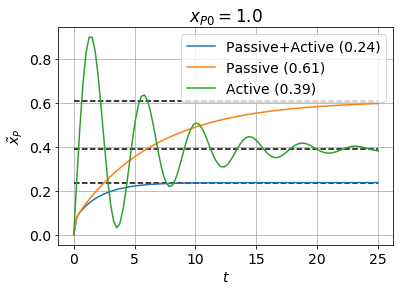

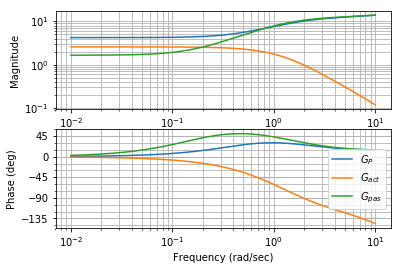

Pgain = 1
[1.73744956e+01 1.20894514e+05 2.85201373e+08 2.41095365e+11
 3.14179228e+13 1.81650960e+15 5.76491919e+16 1.08413608e+18
 1.23857447e+19 8.58408371e+19 3.58499886e+20 9.19554709e+20
 1.46494102e+21 1.42895335e+21 8.06405392e+20 2.27927344e+20
 2.10754159e+19]
[1.00000000e+00 6.96464895e+03 1.64592896e+07 1.39789050e+10
 1.89269590e+12 1.14643465e+14 3.84359691e+15 7.71186507e+16
 9.51400567e+17 7.23105473e+18 3.37995118e+19 9.94581205e+19
 1.87606867e+20 2.26360643e+20 1.68883444e+20 7.09568653e+19
 1.28388500e+19 0.00000000e+00]
Error = 9.1e-06
Passive+Active: pm = 102 degrees  at frequency 1.5e+01 rad/s


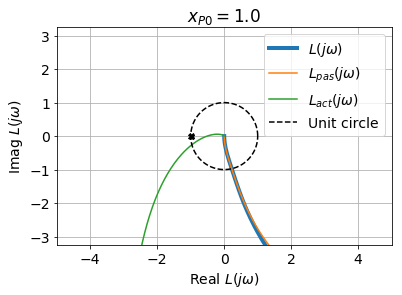

In [39]:
ttp,yyp,Gss_P,Lss_P = splitLoop(X_ss_cl,cont='P',invar=invar)

## Nonlinear simulation

x_P_ss = 0.9999999999999871
x_P_ss = 0.9999999999999871


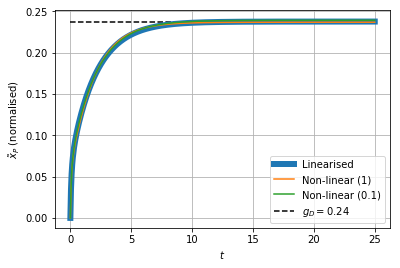

In [40]:
## Nonlinear simulation
dat_P = nsim(s_cl,sc_cl,X_ss_cl,tt_P_cl,yy_P_cl,name='P_sim',invar=invar,g_D=Gss_P[2])


Steady-state finder error: 7.20e-04
{'P0': '0.1+10*t/1000000.0'}


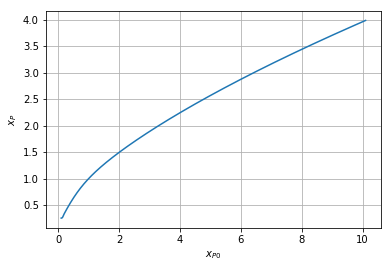

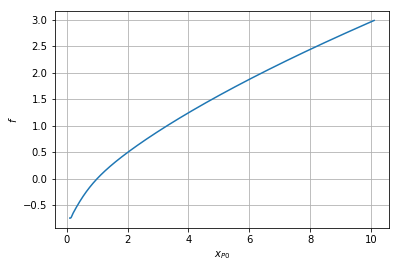

In [41]:
## Steady states
x_P0_P,x_P_P,f_P = SteadySim(s_cl,sc_cl,X_ss_cl,name='P_sim')

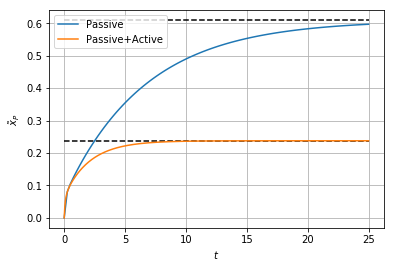

In [42]:
## Compare controllers
#plt.plot(tt_ECR_cl,yy_ECR_cl,label='ECR')
plt.plot(ttp,yyp,label='Passive')
plt.plot(tt_P_cl,yy_P_cl,label='Passive+Active')
plt.hlines([Gss_P[0],Gss_P[2]],
           np.min(tt_P_cl),np.max(tt_P_cl),
          linestyles='dashed')
plt.legend()
plt.grid()
plt.xlabel('$t$')
plt.ylabel(f'${ysymbol}_P$')
plt.savefig('P_step.pdf')


## Vary $x_{P0}$

In [43]:
if Vary_P0:
    P_ss_P,V_ss_P,g_ss_P,l_ss_P = Vary(PP0 = PP0,cont='P',invar='X')

# Cyclic flow modulation: PI control (CFMI)

## Closed loop

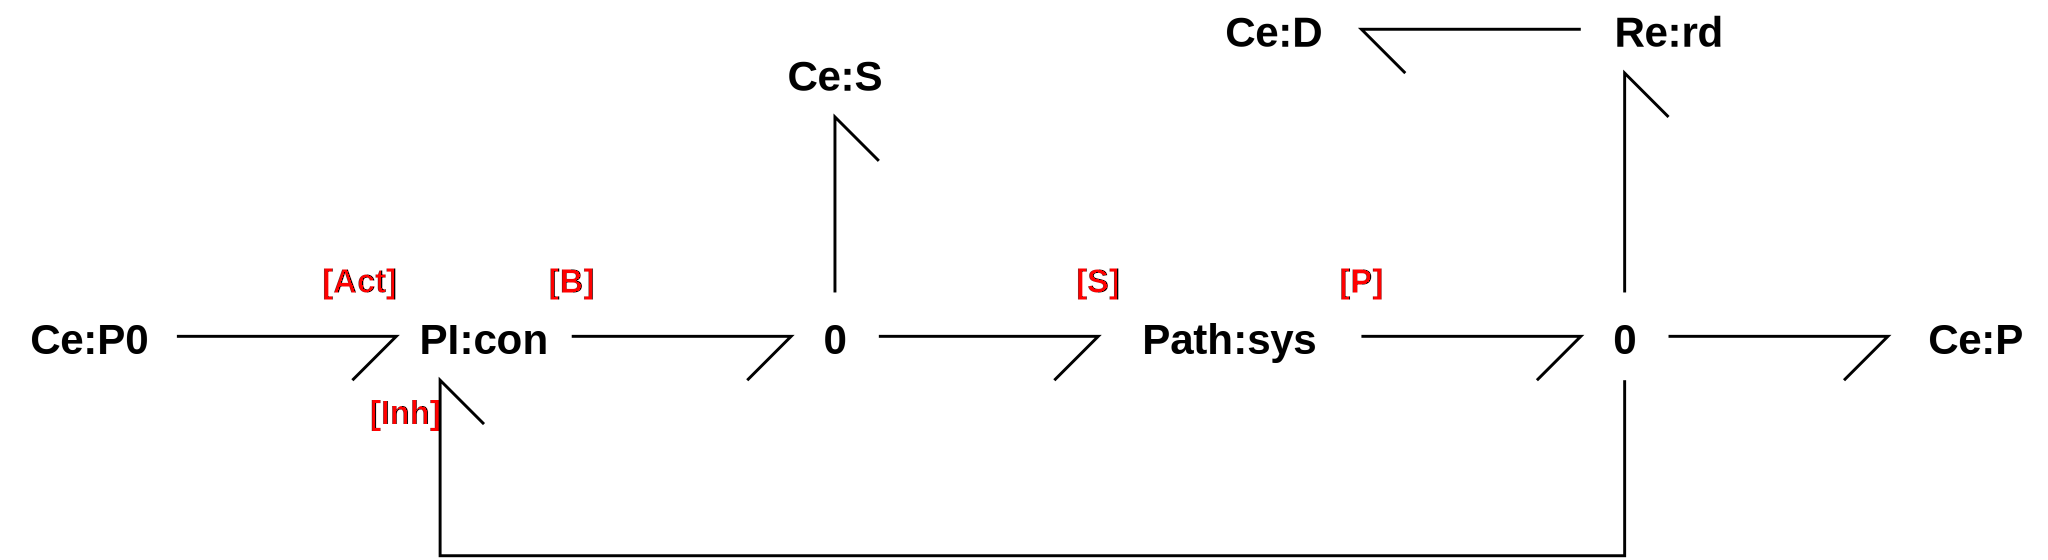

In [44]:
name = 'PIfb'
#PIfb = create(name,quiet=quiet)
disp.SVG(name+'_abg.svg')

In [45]:
## Stoichiometry: closed-loop
#s_cl = st.stoich(PIfb,quiet=quiet)
s_cl = S[name]
chemostats_cl =['P0','D']
chemostats_cl += ['con_A'] 
chemostats_cl += ['con_P_Fwd_ecr_F', 'con_P_Fwd_ecr_G','con_P_Rev_ecr_F', 'con_P_Rev_ecr_G']
chemostats_cl += ['con_I_Fwd_ecr_F', 'con_I_Fwd_ecr_G','con_I_Rev_ecr_F', 'con_I_Rev_ecr_G']

sc_cl = st.statify(s_cl,chemostats=chemostats_cl)

In [46]:
#print(s_cl['species'])

In [47]:
## Parameters
parameter,X0 = setParameter(s_cl,N=0,e_0=e_0,
                             prefixes=['con_P_','con_I_'])


In [48]:
# ## Linearise
# L_cl,G0_cl,Gd_cl,X_ss_cl = Linearise(s_cl,sc_cl,X0=X0,invar=invar)

# ## Step response
# tt_PI_cl,yy_PI_cl = con.step_response(Gd_cl,T=T)
# plt.plot(tt_PI_cl,yy_PI_cl)
# plt.grid()

# x_P_ss = X_ss_cl[s_cl['species'].index('P')]
# print(f'Steady-state x_P = {x_P_ss}')

In [49]:
T = np.linspace(0,50,500)
L_cl,G0_cl,Gd_cl,X_ss_cl,V_ss_cl,tt_PI_cl,yy_PI_cl,x_P_ss,v_ss = closedLoop(s_cl,sc_cl,X0,T=T)



 Analysing PIfb

Steady-state finder error: 2.45e-13
Outvar = X; invar = X
Net gain = 0.0
Steady-state x_P = 0.9999999999999909


## Open-loop


In [50]:
## Stoichiometry: open-loop
#s_ol = st.stoich(PIfb,quiet=quiet)
s_ol = s_cl
chemostats_ol = chemostats_cl + ['P']
sc_ol = st.statify(s_ol,chemostats=chemostats_ol)

In [51]:
## Linearise
L_ol,G0_ol,Gd_ol,X_ss_ol,V_ss_ol = Linearise(s_ol,sc_ol,Inp=['P'],Outp=['P'], 
                                     invar=invar,X_ss=X_ss_cl)
# print(L_ol)
# print(G0_ol)
# print(Gd_ol)


 Analysing PIfb

Outvar = port; invar = X
0 states have been removed from the model
Net gain = -34.7


Pgain = 1
11 states have been removed from the model
2 states have been removed from the model
g0 = 0.95


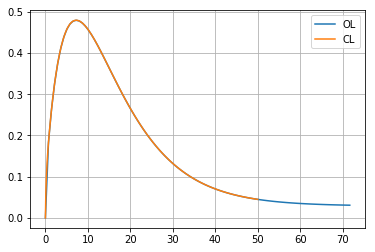

In [52]:
##Closed-loop from open loop
CL,CL_d = OpenToClosed(L_ol,G0_ol,Gd_ol,invar=invar)

# tfError(CL,G0_cl)
# tfError(CL_d,Gd_cl)

tt,yy = con.step_response(CL)
tt_d,yy_d = con.step_response(CL_d)
g0 = con.dcgain(G0_cl)
print(f'g0 = {g0:.2}')
#plt.plot(tt,yy/g0,label='P0 (normalised)')
plt.plot(tt_d,yy_d,label='OL')
plt.plot(tt_PI_cl,yy_PI_cl,label='CL')
plt.legend()
plt.grid()

## Split loop


 Analysing PIsl

Outvar = port; invar = X
0 states have been removed from the model
9 states have been removed from the model
9 states have been removed from the model
4 states have been removed from the model
Net gain = -34.6
Pgain = 1
8 states have been removed from the model
2 states have been removed from the model

 Analysing PIsl

Outvar = port; invar = X
0 states have been removed from the model
Net gain = -1.64

 Analysing PIsl

Outvar = port; invar = X
0 states have been removed from the model
Net gain = -2.56e-11

 Analysing PIsl

Outvar = port; invar = X
2 states have been removed from the model
Net gain = 1.78e-12
Pgain = 1
3 states have been removed from the model
7 states have been removed from the model

 Analysing PIsl

Outvar = port; invar = X
2 states have been removed from the model
Net gain = -33.0
Pgain = 1
9 states have been removed from the model
2 states have been removed from the model

*** Transfer function error = 6.2e-06 ***



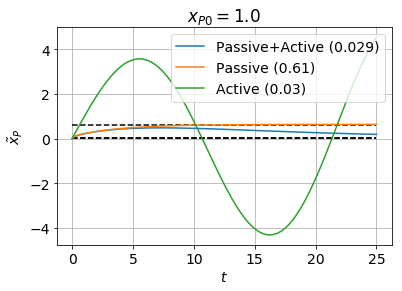

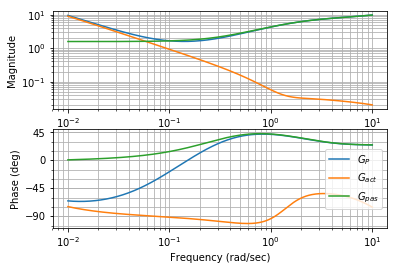

Pgain = 1
[1.86051465e+01 1.43034109e+05 4.03530245e+08 5.06940852e+11
 2.85213336e+14 8.46757006e+16 1.45726869e+19 1.53972487e+21
 1.04674421e+23 4.73361895e+24 1.45213548e+26 3.04531052e+27
 4.35722103e+28 4.21538352e+29 2.72626746e+30 1.17346887e+31
 3.40325081e+31 6.75068045e+31 9.22989865e+31 8.65677660e+31
 5.44448442e+31 2.18139472e+31 4.99872416e+30 5.01313232e+29
 4.07145903e+27 1.14452045e+25 1.08276816e+22]
[1.00000000e+00 7.71372725e+03 2.18863338e+07 2.77976224e+10
 1.60093876e+13 4.92149767e+15 8.88362457e+17 9.97885774e+19
 7.28963201e+21 3.57122145e+23 1.19507672e+25 2.75273865e+26
 4.35847479e+27 4.70462918e+28 3.42396466e+29 1.67200850e+30
 5.54580905e+30 1.26894285e+31 2.02101691e+31 2.23471432e+31
 1.68294946e+31 8.24579279e+30 2.37943099e+30 3.12504560e+29
 2.53591897e+27 7.05796913e+24 6.59597102e+21 0.00000000e+00]
Error = 0.00029
Passive+Active: pm = 114 degrees  at frequency 9.6 rad/s


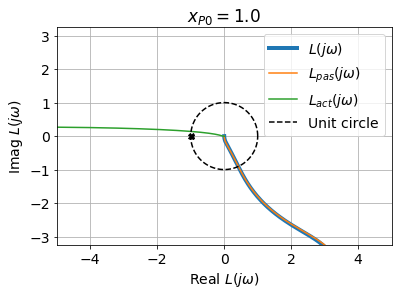

In [53]:
ttp,yyp,Gss_PI,Lss_PI = splitLoop(X_ss_cl,cont='PI',invar=invar)

x_P_ss = 0.9999999999999909
x_P_ss = 0.9999999999999909


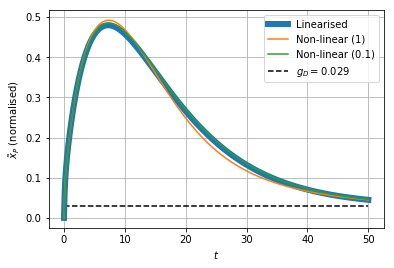

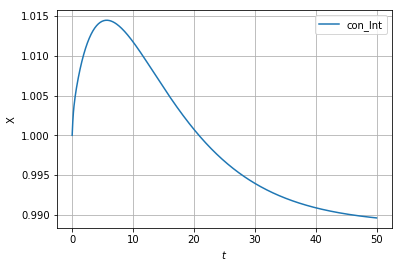

In [54]:
## Nonlinear simulation
dat_PI = nsim(s_cl,sc_cl,X_ss_cl,tt_PI_cl,yy_PI_cl,name='PI_sim',invar=invar,g_D=Gss_PI[2])


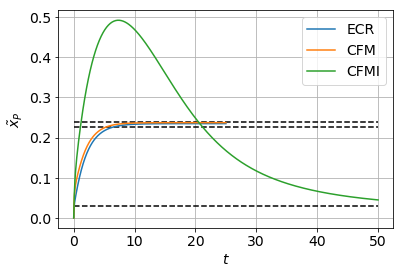

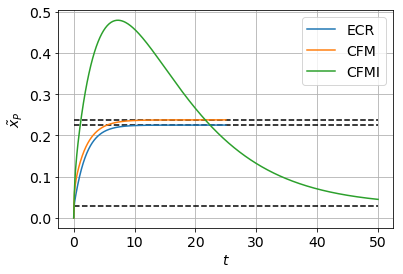

In [55]:
## Compare controllers
#plt.plot(ttp,yyp,label='Passive')
#plotNonlinear = True
BigFont=14
Pad = 20
plt.rcParams.update({'font.size': BigFont})

for plotNonlinear in [True,False]:
    if plotNonlinear:
        plt.plot(dat_ECR['t'], dat_ECR['dx_P'],label='ECR')
        plt.plot(dat_P['t'], dat_P['dx_P'] ,label='CFM')
        plt.plot(dat_PI['t'], dat_PI['dx_P'] ,label='CFMI')
    else:
        plt.plot(tt_ECR_cl,yy_ECR_cl,label='ECR')
        plt.plot(tt_P_cl,yy_P_cl,label='CFM')
        plt.plot(tt_PI_cl,yy_PI_cl,label='CFMI')

    gg_d = [Gss[2],Gss_P[2],Gss_PI[2]]
    for g_d in gg_d:
        plt.hlines(g_d,np.min(tt_PI_cl),np.max(tt_PI_cl),
              linestyles='dashed')
                   ##,label=f'$g_D={g_d:0.2}$')
    plt.legend(loc='upper right')
    plt.grid()
    plt.xlabel('$t$')
    plt.ylabel(f'${ysymbol}_P$')
    #plt.show()
    if plotNonlinear:
        plotname = 'PI_nstep.pdf'
    else:
        plotname = 'PI_step.pdf'
    plt.savefig(plotname,
        box_inches='tight',pad_inches=Pad)
    plt.show()
plt.rcParams.update({'font.size': 10})


Steady-state finder error: 1.19e-03
{'P0': '0.1+10*t/1000000.0'}


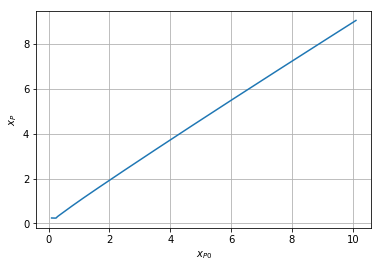

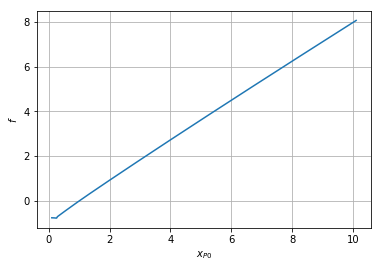

In [56]:
## Steady states
x_P0_PI,x_P_PI,f_PI = SteadySim(s_cl,sc_cl,X_ss_cl,name='PI_sim',invar=invar)

# Compare steady states


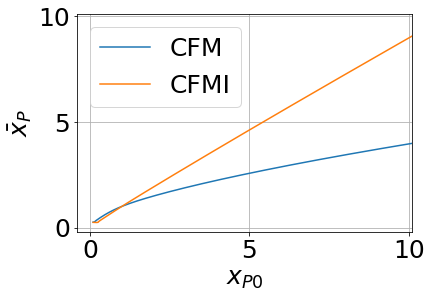

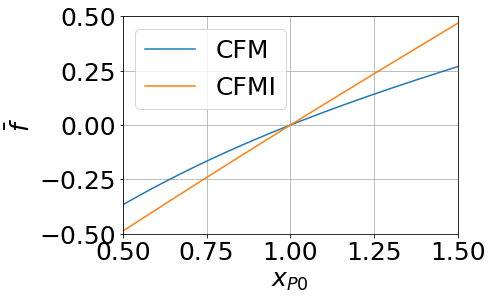

In [57]:
## Compare steady-states
#plt.plot(x_P0_ECR,x_P_ECR,label='ECR')
BigFont = 25
Pad = 0.1

plt.rcParams.update({'font.size': BigFont})
plt.plot(x_P0_P,x_P_P,label='CFM')
plt.plot(x_P0_PI,x_P_PI,label='CFMI')
plt.ylim(top=max(x_P0_P))
plt.xlim(right=max(x_P0_P))
plt.grid()
plt.legend()
plt.ylabel(r'${\bar{x}}_P$')
plt.xlabel('$x_{P0}$')
plt.savefig('x_ss.pdf',bbox_inches='tight',pad_inches=Pad)
plt.show()


#plt.plot(x_P0_ECR,x_P_ECR,label='ECR')
#plt.rcParams.update({'font.size': BigFont})
plt.plot(x_P0_P,f_P,label='CFM')
plt.plot(x_P0_PI,f_PI,label='CFMI')
plt.grid()
plt.xlim((0.5,1.5))
plt.ylim((-0.5,0.5))
plt.legend()
plt.ylabel(r'$\bar{f}$')
plt.xlabel('$x_{P0}$')
plt.savefig('f_ss.pdf',bbox_inches='tight',pad_inches=Pad)
plt.show()



## Vary $x_{P0}$

In [58]:
if Vary_P0:
    P_ss_PI,V_ss_PI,g_ss_PI,l_ss_PI = Vary(PP0 = PP0,cont='PI',invar='X')

In [59]:
if Vary_P0:
    plt.plot(PP0,P_ss_ECR,label='ECR')
    plt.plot(PP0,P_ss_P,label='CFM')
    plt.plot(PP0,P_ss_PI,label='CFMI')
    plt.legend()
    plt.ylim((0,5))
    plt.grid()
    plt.xlabel('$x_{P0}$')
    plt.ylabel(r'$\bar{x}_P$')
    plt.savefig('P_ss.pdf')

In [60]:
#plt.plot(PP0,V_ss,label='ECR')
if Vary_P0:
    plt.plot(PP0,V_ss_ECR,label='ECR')
    plt.plot(PP0,V_ss_P,label='CFM')
    plt.plot(PP0,V_ss_PI,label='CFMI')
    plt.legend()
    plt.grid()
    plt.ylim((-1,5))
    plt.xlabel('$x_{P0}$')
    plt.ylabel(r'$\bar{v}_P$')
    plt.savefig('V_ss.pdf')

In [61]:
#plt.loglog(PP0,g_ss,label='ECR')
if Vary_P0:
    plt.plot(PP0,g_ss_ECR,label='ECR')
    plt.plot(PP0,g_ss_P,label='CFM')
    plt.plot(PP0,g_ss_PI,label='CFMI')
    plt.legend()
    plt.grid()
    plt.xlabel('$x_{P0}$')
    plt.ylabel('$g_D$')
    plt.savefig('g_ss.pdf')

In [63]:
## Print out reactions
texFile = open('reac.tex','w')
for sys in S:
    texFile.write(r'\subsection{Module '+sys+'}\n')
    s = S[sys]
    texFile.write(st.sprintrl(s,chemformula=True).replace('_','.'))